In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy 
import itertools

# Стой!!! Это переиспользование лабы Санька (Simankovich)
# STOP!!! Simankovich

In [2]:
def read_excel(filename, usecols, header, nrows = None, sheet_name = 0):
    '''
    Creates pandas.DataFrame from excel file with pandas.MultiIndex.

    :param filename:   name of excel file
    :param usecols:    int list with indices of columns to read
    :param header:     int list with indices of header rows
    :param sheet_name: index or name of sheet to read
    '''
    if header == None or header == 0:
        return pd.read_excel(filename, header = header, usecols = usecols, nrows = nrows, sheet_name = sheet_name)

    # Read header rows
    __header_df = pd.read_excel(filename, nrows = 0, header = header, sheet_name = sheet_name)
    __header_mi = pd.MultiIndex.from_tuples(__header_df.columns.to_list())

    # Read data and set multiindex
    __data = pd.read_excel(filename, skiprows = header, header = None, usecols = usecols, nrows = nrows, sheet_name = sheet_name)
    __data.columns = __header_mi[usecols]

    return __data

def map_excel(data, fmt):
    '''
    Renames columns in pandas.DataFrame.

    :param __data: pandas.DataFrame to rename columns in
    :param __fmt:  map old_names->new_names

    Example:
        fmt = {
            'B, Wb' : 'B',
            'Webermeter' : 'Wm',
            'L, m' : 'L'
        }

        data = map_excel(data, fmt)
    '''

    return data.rename(columns = fmt)

In [3]:
def interp_linear(x, y):
    coeffs = np.polyfit(x, y, 1)
    return lambda x: coeffs[0] * x + coeffs[1]

PLOT_MARKER = itertools.cycle(['.', 'v', '^', '<', '>', '*', 'd', 's', 'o'])
def plot(x, y, label = None, color = None, xerr = 0, yerr = 0,
         begin = 0, end = None, exclude = [],
         x_min = None, x_max = None, func = interp_linear, unique_marker='.'):
    '''
    Creates plot with approximating line.

    :param x:                   x coordinates of points
    :param y:                   y coordinates of points
    :param label:               label of plot in legend
    :param color:               color of plot
    :param xerr:                x errors of points
    :param yerr:                y errors of points
    :param begin:               index of first point used for approximating line
    :param end:                 index of last point used for approximating line
    :param exclude:             indices of 'error' points
    :param x_min:               left end of approximating line
    :param x_max:               right end of approximating line
    :param func:                function for approximating
    :param unique_marker:       True -> use internal unique marker, otherwise use unique_marker as marker itself

    :return x_clean, y_clean: pd.Series of values used for approximating line
    '''
    
    assert len(x) == len(y), "x and y must have same length"
    
    end = (len(x) - 1) if (end == None) else end
    
    x_clean = []
    y_clean = []
    for i in range(begin, end + 1):
        if i in exclude:
            continue
        x_clean.append(x[i])
        y_clean.append(y[i])
    
    x_min = min(x_clean) if (x_min == None) else x_min
    x_max = max(x_clean) if (x_max == None) else x_max

    equ = func(x_clean, y_clean)
    x_space = np.linspace(x_min, x_max, 100)
    
    if unique_marker == True:
        unique_marker = next(PLOT_MARKER)
    
    p = plt.plot(x_space, equ(x_space), label = label, c = color)
    plt.errorbar(x, y, xerr = xerr, yerr = yerr, fmt = unique_marker, c = p[-1].get_color())

    for i in exclude:
        plt.scatter(x[i], y[i], s = 60, marker = 'x', c = 'red')

    return pd.Series(x_clean), pd.Series(y_clean), equ


In [4]:
def rename(columns, fmt, inplace = False):
    __init_columns = columns
    __columns = __init_columns 
    
    for key in fmt.keys():
        __renamed = []
        
        for i in range(len(__init_columns)):
            col = __columns[i]

            if type(key) is tuple:
                if type(col) is tuple and __init_columns[i][:len(key)] == key:
                    col = __columns[i][:len(key) - 1] + (fmt[key],) + __columns[i][len(key):]
            elif type(key) is str:
                if type(col) is str and col == key:
                    col = fmt[key]
                elif type(col) is tuple and col[0] == key:
                    col = (fmt[key],) + __columns[i][1:]
            else:
                assert 0, 'Format index must be str or tuple'
                
            __renamed.append(col) 
        
        __columns = __renamed
                    
    return __columns #pd.Index(__columns, tupleize_cols = True)

class table:
    data = pd.DataFrame()
    latex_fmt = {
        # key    name      precision
        # 'I' : ['$I$, A', '{:.1f}'],
        # ('Group', 'I') : ['$I$, A', '{:.1f}'],
    }

    DEFAULT_PRECISION = '{:.1f}'
    DEFAULT_NAME = '!unnamed!'

    def __init__(self, data, fmt = {}):
        self.data = data
        self.latex_fmt = fmt
        
    def get_names(self):
        __fmt = self.latex_fmt
        return {__i:__fmt[__i][0] for __i in __fmt.keys() if len(__fmt[__i]) > 0}

    def get_precisions(self):
        __fmt = self.latex_fmt
        return {__i:__fmt[__i][1] for __i in __fmt.keys() if len(__fmt[__i]) > 1}

    def get_scales(self):
        __fmt = self.latex_fmt
        return {__i:__fmt[__i][2] for __i in __fmt.keys() if len(__fmt[__i]) > 2}

    def get_fmt(self):
        return self.latex_fmt
    
    def get_data(self):
        return self.data
    
    def set_name(self, key, name):
        if key in self.latex_fmt:
            __tmp = self.latex_fmt[key]
            __tmp[0] = name
        else:
            __tmp = [name, DEFAULT_PRECISION]

        self.latex_fmt[key] = __tmp

    def set_precision(self, key, precision):
        if key in self.latex_fmt:
            __tmp = self.latex_fmt[key]
            __tmp[1] = precision
        else:
            __tmp = [DEFAULT_NAME, precision]
        
        self.latex_fmt[key] = __tmp

    def set_fmt(self, fmt):
        self.latex_fmt = fmt
    
    def scale(self):
        __tab = table(self.data.copy(), self.latex_fmt.copy())
        
        __scales = self.get_scales()
        for key in list(__scales.keys()):
            if key in list(__tab.data.columns.values):
                __tab.data[key] *= 10**(__scales[key])

        return __tab
    
    def rename(self):
        __tab = table(self.data.copy(), self.latex_fmt.copy())
        
        __tab.data.columns = pd.Index(rename(__tab.data.columns.values, __tab.get_names()), tupleize_cols = True)
        __tab.latex_fmt = dict(zip(rename(list(__tab.latex_fmt.keys()), __tab.get_names()), list(__tab.latex_fmt.values())))
            
        return __tab  
        
    def insert(self, loc, column, value, fmt = []):
        assert not (column in self.data), "Column " + str(column) + " already exists"
        self.data.insert(loc = loc, column = column, value = value, allow_duplicates = False)
        
        if fmt:
            self.latex_fmt[column] = fmt
        
    def delete(self, column):
        assert (column in self.data), "Column " + str(column) + " does not exist"
        del self.data[column]
            
    def to_latex(self, file = None):
        '''
        Applies LaTeX formatting and saves table to file.
        
        :param filename: output file
        
        Example:
        
        fmt = {
            'x': ['$x$, дел.',   '{:.1f}'],
            'x0': ['$x_0$, дел.', '{:.3f}'],
            
            # It supports multi index renaming
            ('RC', 'R'): ['$R$, дел.',   '{:.2f}'], 
        }
        
        my_table.to_latex('my_table.tex')
        '''
        
        # Rename also changes latex_fmt. 
        # That is why we need to assign rename() to local variable
        __tab = self.rename() 
        return __tab.scale().data.style.format(__tab.get_precisions()) \
                    .hide(level=0, axis=0)                                 \
                    .to_latex( 
                        buf = file,
                        column_format="c" * len(__tab.data.columns.values),
                        hrules=True,
                        multicol_align = 'c',
                        environment = ''
                    )
    
    
def mnk(x, y, fmt = None, file = None, precision = 2):

    if fmt == None:
        fmt = {
                '<x>':    ['$\overline{x}$', '{:.' + str(precision) + 'e}'],
                'sx':     ['$\sigma_x^2$',   '{:.' + str(precision) + 'e}'],
                '<y>':    ['$\overline{y}$', '{:.' + str(precision) + 'f}'],
                'sy':     ['$\sigma_y^2$',   '{:.' + str(precision) + 'e}'],
                'rxy':    ['$r_{xy}$',       '{:.' + str(precision) + 'e}'],
                'a':      ['$a$',            '{:.' + str(precision) + 'f}'],
                'da':     ['$\Delta a$',     '{:.' + str(precision) + 'f}'],
                'b':      ['$b$',            '{:.' + str(precision) + 'f}'],
                'db':     ['$\Delta b$',     '{:.' + str(precision) + 'f}'],
        }
    
    __sx = (x**2).mean() - (x.mean())**2
    __sy = (y**2).mean() - (y.mean())**2
    
    __rxy = (y*x).mean() - (y.mean() * x.mean())
    
    __a  = __rxy / __sx
    __da = (1/(len(x) - 2) * (__sy/__sx - __a**2))**(0.5)
    
    __b  = y.mean() - __a * x.mean()
    __db = __da*(__sx + (x.mean())**2)**(1/2)

    __data = pd.DataFrame({
        '<x>':   [x.mean()],
        'sx':    [__sx],
        '<y>':   [y.mean()],
        'sy':    [__sy],
        'rxy':   [__rxy],
        'a':     [__a],
        'da':    [__da],
        'b':     [__b],
        'db':    [__db],
    })
    
    __tab = table(__data, fmt)
    if file:
        __tab.to_latex(file)
    
    return __tab

In [5]:
class setup:
    dummy = 0
    
    em_SN = 75 * 10**-4    # m^2 -- effective area of probe coil
    wb_err = 0.015 * 10    # mWb -- error of webermeter
    tl_eps = 0.06          #     -- relative error of teslameter
    em_supply = 0.005      # A   -- error of electromagnet power supply
    
    B_eps = 0.05           #     -- relative error of magnetic field
    A2_err = 0.005         # mA  -- relative error of main current in plate
    V1_err = 3.5           # mkV -- error of Hall's EMF
    plate_h = 1.0          # mm  -- plate thickness
    plate_l = 5.0          # mm  -- plate length
    plate_a = 4.0          # mm  -- plate width
    plate_err = 0.05       # mm  -- error of plate size


## Electromagnet calibration

In [62]:
xls = {
    'I, A' : 'I',
    'Phi, mWb' : 'Phi',
    'B, mT' : 'B'
}

em_data = read_excel("data/334.xlsx", usecols=range(0, 4), header=[0, 1], nrows = 10)
em_data = map_excel(em_data, xls)
em_data

Webermeter                           
           I  Phi Phi, mWb.1 Phi, mWb.2
0       0.15  1.2        NaN        NaN
1       0.30  2.0        NaN        NaN
2       0.45  3.0        NaN        NaN
3       0.60  3.9        NaN        NaN
4       0.75  4.9        NaN        NaN
5       0.90  5.7        NaN        NaN
6       1.05  6.5        NaN        NaN
7       1.20  7.0        NaN        NaN
8       1.35  7.4        NaN        NaN
9       1.50  7.8        NaN        NaN

In [63]:
wb_B = em_data[('Webermeter', 'Phi')] / setup.em_SN
print(wb_B)

em_fmt = {
    'Webermeter' : ['Веберметр'],
    'Teslameter' : ['Тесламетр'],
    ('Webermeter', 'I') : ['$I_M$, А', '{:.2f}', 0],
    ('Webermeter', 'Phi') : ['$\Phi$, мВб', '{:.1f}', 0],
    ('Webermeter', 'B') : ['$B$, мТл', '{:.0f}', 0],
    ('Teslameter', 'I') : ['$I_M$, А', '{:.2f}', 0],
    ('Teslameter', 'B') : ['$B$, мТл', '{:.0f}', 0],
}

em_tbl = table(em_data, em_fmt)
em_tbl.insert(2, ('Webermeter', 'B'), wb_B)
em_tbl.rename().to_latex('gen/electromagnet.tex')

0     160.000000
1     266.666667
2     400.000000
3     520.000000
4     653.333333
5     760.000000
6     866.666667
7     933.333333
8     986.666667
9    1040.000000
Name: (Webermeter, Phi), dtype: float64


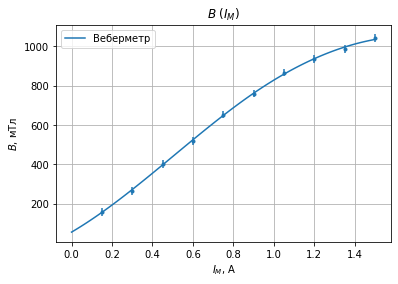

In [64]:
def interp_spl(x, y):
    return UnivariateSpline(x, y, s=300)

d = em_tbl.get_data()
x, y, wb_equ = plot(d[('Webermeter', 'I')], d[('Webermeter', 'B')], label = 'Веберметр',
                    xerr = setup.em_supply, yerr = setup.wb_err / setup.em_SN, x_min = 0, func = interp_spl)

plt.title("$B \; (I_M)$")
plt.xlabel("$I_M$, А")
plt.ylabel("$B$, мТл")
plt.grid(True)
plt.legend()

plt.savefig("gen/electromagnet_BI.pdf")


In [65]:
mnk(d[('Webermeter', 'I')], d[('Webermeter', 'B')], file = 'gen/webermeter_mnk.tex').get_data()

,<x>,sx,<y>,sy,rxy,a,da,b,db
0,0.825,0.185625,658.666667,87047.111111,125.8,677.710438,34.729722,99.555556,32.323838


## Hall's EMF

In [66]:
xls = {
    'I, mA' : 'I',
    'I, A' : 'I',
    'U_34, mkV' : 'U'
}

cols = range(15, 29)
print('Cols:', cols)

he_data = read_excel("data/334.xlsx", usecols = cols, header = [0, 1, 2])
he_data = map_excel(he_data, xls)

xls = {
    'I, mA' : 'I',
    'U_0, mkV' : 'U'
}

u0_data = read_excel("data/334.xlsx", usecols = [10, 11], header = [0, 1], nrows = 7)
u0_data = map_excel(u0_data, xls)
u0_data = u0_data['Disbalance']
print(u0_data)

u0_dict = {
    u0_data['I'][indx] : u0_data['U'][indx] for indx in range(0, len(u0_data))
}
print(u0_dict)

he_data

Cols: range(15, 29)
      I   U
0  0.15   0
1  0.30  -3
2  0.45  -6
3  0.60  -9
4  0.75 -12
5  0.90 -16
6  1.00 -18
{0.15: 0, 0.3: -3, 0.45: -6, 0.6: -9, 0.75: -12, 0.9: -16, 1.0: -18}


I                                                                       
   0.15       0.30       0.45       0.60       0.75       0.90       1.00     
      I    U     I    U     I    U     I    U     I    U     I    U     I    U
0  0.15  -14  0.15  -32  0.15  -49  0.15  -69  0.15  -83  0.15 -101  0.15 -114
1  0.30  -30  0.30  -64  0.30  -97  0.30 -131  0.30 -162  0.30 -201  0.30 -219
2  0.45  -47  0.45  -96  0.45 -144  0.45 -195  0.45 -241  0.45 -296  0.45 -326
3  0.60  -62  0.60 -125  0.60 -190  0.60 -258  0.60 -320  0.60 -386  0.60 -429
4  0.75  -77  0.75 -155  0.75 -235  0.75 -318  0.75 -395  0.75 -476  0.75 -532
5  0.90  -91  0.90 -182  0.90 -275  0.90 -370  0.90 -461  0.90 -556  0.90 -618
6  1.05 -103  1.05 -205  1.05 -310  1.05 -415  1.05 -520  1.05 -622  1.05 -695
7  1.20 -111  1.20 -222  1.20 -335  1.20 -450  1.20 -559  1.20 -673  1.20 -749
8  1.35 -118  1.35 -236  1.35 -354  1.35 -474  1.35 -592  1.35 -714  1.35 -793
9  1.50 -122  1.50 -246  1.50 -369  1.50 -495  1.50 -617  1.50 -744  1.50 -828

In [67]:
# Get values of I in index
cols = list(dict.fromkeys(he_data.columns.get_level_values(1)))
print(cols)

# Subtract U_0 for all U
assert len(u0_dict.keys()) == len(cols), "U_0 amount and amount of I in index doesn't match"
for num in cols:
    he_data[('I', num, 'U')] -= u0_dict[num]

# Convert I in index from float to string (0.9 -> '0.90')
cols = ['{:.2f}'.format(num) for num in cols]
he_data.columns = he_data.columns.set_levels(cols, level = 1)
print(he_data.columns)

he_data

[0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.0]
MultiIndex([('I', '0.15', 'I'),
            ('I', '0.15', 'U'),
            ('I', '0.30', 'I'),
            ('I', '0.30', 'U'),
            ('I', '0.45', 'I'),
            ('I', '0.45', 'U'),
            ('I', '0.60', 'I'),
            ('I', '0.60', 'U'),
            ('I', '0.75', 'I'),
            ('I', '0.75', 'U'),
            ('I', '0.90', 'I'),
            ('I', '0.90', 'U'),
            ('I', '1.00', 'I'),
            ('I', '1.00', 'U')],
           )


I                                                                       
   0.15       0.30       0.45       0.60       0.75       0.90       1.00     
      I    U     I    U     I    U     I    U     I    U     I    U     I    U
0  0.15  -14  0.15  -29  0.15  -43  0.15  -60  0.15  -71  0.15  -85  0.15  -96
1  0.30  -30  0.30  -61  0.30  -91  0.30 -122  0.30 -150  0.30 -185  0.30 -201
2  0.45  -47  0.45  -93  0.45 -138  0.45 -186  0.45 -229  0.45 -280  0.45 -308
3  0.60  -62  0.60 -122  0.60 -184  0.60 -249  0.60 -308  0.60 -370  0.60 -411
4  0.75  -77  0.75 -152  0.75 -229  0.75 -309  0.75 -383  0.75 -460  0.75 -514
5  0.90  -91  0.90 -179  0.90 -269  0.90 -361  0.90 -449  0.90 -540  0.90 -600
6  1.05 -103  1.05 -202  1.05 -304  1.05 -406  1.05 -508  1.05 -606  1.05 -677
7  1.20 -111  1.20 -219  1.20 -329  1.20 -441  1.20 -547  1.20 -657  1.20 -731
8  1.35 -118  1.35 -233  1.35 -348  1.35 -465  1.35 -580  1.35 -698  1.35 -775
9  1.50 -122  1.50 -243  1.50 -363  1.50 -486  1.50 -605  1.50 -728  1.50 -810

In [68]:
he_tbl_UI = table(he_data)
he_tbl_UB = copy.deepcopy(he_tbl_UI)

# Convert I to B using magnet calibration
for num in cols:
    new_B = wb_equ(he_data[('I', num, 'I')])
    new_loc = he_data.columns.get_loc(('I', num, 'I'))
    he_tbl_UB.delete(('I', num, 'I'))
    he_tbl_UB.insert(value = new_B, column = ('I', num, 'B'), loc = new_loc)

he_tbl_UB.get_data()

I                                                             \
          0.15              0.30              0.45              0.60        
             B    U            B    U            B    U            B    U   
0   156.603428  -14   156.603428  -29   156.603428  -43   156.603428  -60   
1   272.486974  -30   272.486974  -61   272.486974  -91   272.486974 -122   
2   397.460628  -47   397.460628  -93   397.460628 -138   397.460628 -186   
3   524.975507  -62   524.975507 -122   524.975507 -184   524.975507 -249   
4   648.482723  -77   648.482723 -152   648.482723 -229   648.482723 -309   
5   761.433392  -91   761.433392 -179   761.433392 -269   761.433392 -361   
6   858.181886 -103   858.181886 -202   858.181886 -304   858.181886 -406   
7   936.695603 -111   936.695603 -219   936.695603 -329   936.695603 -441   
8   995.845198 -118   995.845198 -233   995.845198 -348   995.845198 -465   
9  1034.501326 -122  1034.501326 -243  1034.501326 -363  1034.501326 -486   

                                                         
          0.75              0.90              1.00       
             B    U            B    U            B    U  
0   156.603428  -71   156.603428  -85   156.603428  -96  
1   272.486974 -150   272.486974 -185   272.486974 -201  
2   397.460628 -229   397.460628 -280   397.460628 -308  
3   524.975507 -308   524.975507 -370   524.975507 -411  
4   648.482723 -383   648.482723 -460   648.482723 -514  
5   761.433392 -449   761.433392 -540   761.433392 -600  
6   858.181886 -508   858.181886 -606   858.181886 -677  
7   936.695603 -547   936.695603 -657   936.695603 -731  
8   995.845198 -580   995.845198 -698   995.845198 -775  
9  1034.501326 -605  1034.501326 -728  1034.501326 -810

In [69]:
he_fmt = {
    'I' : ['$I$, мА']
}
# Add I, U, B to format for all index currents in both tables
he_fmt.update({('I', num, 'I') : ['$I_M$, А', '{:.2f}'] for num in he_data.columns.get_level_values(1)})
he_fmt.update({('I', num, 'U') : ['$U$, мкВ', '{:.0f}'] for num in he_data.columns.get_level_values(1)})
he_fmt.update({('I', num, 'B') : ['$B$, мТл', '{:.0f}'] for num in he_data.columns.get_level_values(1)})

he_tbl_UI.set_fmt(he_fmt)
he_tbl_UB.set_fmt(he_fmt)
he_tbl_UI.rename().to_latex('gen/hallEMF_UI.tex')
he_tbl_UB.rename().to_latex('gen/hallEMF_UB.tex')

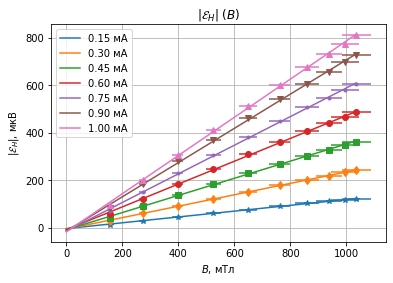

In [70]:
d = he_tbl_UB.get_data()
he_K = []
he_K_err = []
he_I = []
he_I_err = []

for num in cols:
    x_clean, y_clean, equ = plot(d[('I', num, 'B')], abs(d[('I', num, 'U')]), label = num + ' мА',
                                 xerr = setup.B_eps * d[('I', num, 'B')], yerr = setup.V1_err, x_min = 0,
                                 unique_marker=True)
    mnk_tbl = mnk(x_clean, y_clean)
    he_K.append(float(mnk_tbl.get_data()['a']))
    he_K_err.append(float(mnk_tbl.get_data()['da']))
    he_I.append(float(num))
    he_I_err.append(setup.A2_err)

plt.title("$|\mathcal{E}_H| \; (B)$")
plt.xlabel("$B$, мТл")
plt.ylabel("$|\mathcal{E}_H|$, мкВ")
plt.grid(True)
plt.legend()

plt.savefig("gen/hallEMF_UB.pdf")


,I,K,I_err,K_err
0,0.15,0.122340,0.005,0.001359
1,0.30,0.240465,0.005,0.001955
2,0.45,0.360712,0.005,0.003407
3,0.60,0.480334,0.005,0.004909
4,0.75,0.602350,0.005,0.006341
5,0.90,0.720236,0.005,0.007796
6,1.00,0.803729,0.005,0.008365


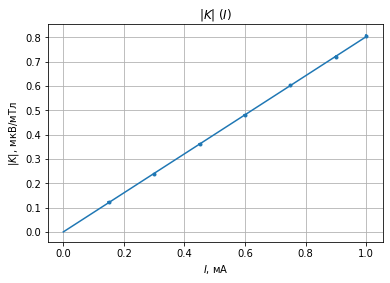

In [71]:
he_tbl_KI = table(pd.DataFrame())
he_tbl_KI.insert(loc = 0, column = 'I', value = he_I, fmt = [r'$I$, мА', '{:.3f}', 0])
he_tbl_KI.insert(loc = 1, column = 'K', value = he_K, fmt = [r'$|K|$, $\frac{\text{мкВ}}{\text{мТл}}$', '{:.3f}', 0])
he_tbl_KI.insert(loc = 2, column = 'I_err', value = he_I_err, fmt = [r'$\Delta I$, мА', '{:.3f}', 0])
he_tbl_KI.insert(loc = 3, column = 'K_err', value = he_K_err, fmt = [r'$\Delta |K|$, $\frac{\text{мкВ}}{\text{мТл}}$', '{:.3f}', 0])

he_tbl_KI.rename().to_latex('gen/hallEMF_KI.tex')

x_clean, y_clean, equ = plot(he_I, he_K, xerr = he_I_err, yerr = he_K_err, x_min = 0)
mnk_tbl = mnk(x_clean, y_clean, file = 'gen/hallEMF_KI_mnk.tex', precision = 3)

plt.title("$|K| \; (I)$")
plt.xlabel("$I$, мА")
plt.ylabel("$|K|$, мкВ/мТл")
plt.grid(True)

plt.savefig("gen/hallEMF_KI.pdf")

he_tbl_KI.get_data()

In [72]:
m = mnk_tbl.get_data()

R_H = setup.plate_h * float(m['a']) * 10 ** -3
R_H_err = R_H * np.sqrt( (float(m['da'])/float(m['a'])) ** 2 + (setup.plate_err / setup.plate_h) ** 2 )
print('R_H = ({:.2e} +- {:.2e})'.format(R_H, R_H_err))

n = 1 / (R_H * 1.6 * 10 ** -19)
n_err = n * R_H_err / R_H
print('n = ({:.2e} +- {:.2e})'.format(n, n_err))

R_H = (8.01e-04 +- 4.01e-05)
n = (7.80e+21 +- 3.90e+20)


R_H = (7.90e-04 +- 3.96e-05)
n = (7.91e+21 +- 3.96e+20)


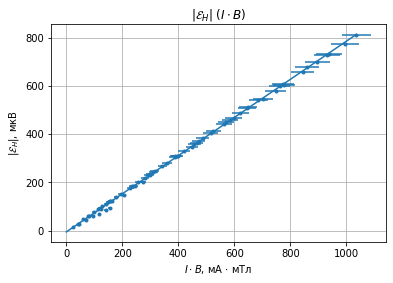

In [73]:
he_IB = []
he_U = []

for num in cols:
    for idx in range(0, len(d[('I', num, 'B')])):
        he_IB.append(float(num) * d[('I', num, 'B')][idx])
        he_U.append(abs(d[('I', num, 'U')][idx]))

x, y, equ = plot(he_IB, he_U, xerr = setup.B_eps * np.array(he_IB), yerr = setup.V1_err, x_min = 0)
mnk_tbl = mnk(x, y, file = 'gen/hallEMF_UIB_mnk.tex', precision = 3)

plt.title("$|\mathcal{E}_H| \; (I \cdot B)$")
plt.xlabel("$I \cdot B$, мА $\cdot$ мТл")
plt.ylabel("$|\mathcal{E}_H|$, мкВ")
plt.grid(True)

plt.savefig("gen/hallEMF_UIB.pdf")

m = mnk_tbl.get_data()

R_H = setup.plate_h * float(m['a']) * 10 ** -3
R_H_err = R_H * np.sqrt( (float(m['da'])/float(m['a'])) ** 2 + (setup.plate_err / setup.plate_h) ** 2 )
print('R_H = ({:.2e} +- {:.2e})'.format(R_H, R_H_err))

n = 1 / (R_H * 1.6 * 10 ** -19)
n_err = n * R_H_err / R_H
print('n = ({:.2e} +- {:.2e})'.format(n, n_err))

## Conductivity

In [74]:
xls = {
    'I, mA' : 'I',
    'U_35, mV' : 'U',
}

cond_data = read_excel("data/334.xlsx", usecols = range(6, 8), header = 0, nrows = 7)
cond_data = map_excel(cond_data, xls)
cond_data

,I,U
0,1.00,3.996
1,0.90,3.592
2,0.75,2.989
3,0.60,2.383
4,0.45,1.785
5,0.30,1.196
6,0.15,0.595


In [75]:
cond_fmt = {
    'I' : ['$I$, мА', '{:.2f}', 0],
    'U' : ['$U_{35}$, мВ', '{:.3f}', 0],
}

cond_tbl = table(cond_data, cond_fmt)
cond_tbl.rename().to_latex('gen/cond_UI.tex')

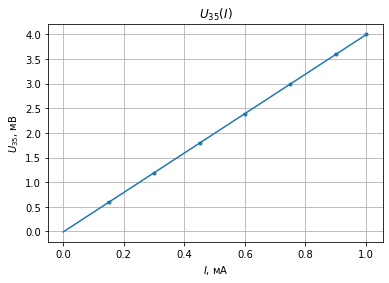

In [76]:
d = cond_tbl.get_data()
x_clean, y_clean, equ = plot(d['I'], d['U'], xerr = setup.A2_err, yerr = setup.V1_err / 10 ** 3, x_min = 0)
mnk_tbl = mnk(x_clean, y_clean, file = 'gen/cond_UI_mnk.tex')
cond_k = float(mnk_tbl.get_data()['a'])

plt.title("$U_{35} (I)$")
plt.xlabel("$I$, мА")
plt.ylabel("$U_{35}$, мВ")
plt.grid(True)

plt.savefig("gen/cond_UI.pdf")


In [77]:
m = mnk_tbl.get_data()

sigma_0 = setup.plate_l / (float(m['a']) * setup.plate_h * setup.plate_a) * 10**3
sigma_0_err = sigma_0 * np.sqrt( (float(m['da'])/float(m['a']))**2 + 3*(setup.plate_err / setup.plate_h)**2 )
print('sigma_0 = ({:.2e} +- {:.2e})'.format(sigma_0, sigma_0_err))

b = sigma_0 / (1.6 * 10**-19 * n) * 10**4
b_err = b * np.sqrt( (sigma_0_err / sigma_0)**2 + (n_err / n)**2 )
print('b = ({:.2e} +- {:.2e})'.format(b, b_err))

sigma_0 = (3.13e+02 +- 2.71e+01)
b = (2.47e+03 +- 2.47e+02)
